<a href="https://colab.research.google.com/github/vivekgautamgv/Python-For-Finance/blob/main/Complete_Mean_Reversion_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install yahoo_fin

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.3 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=3de8c8d184ae03ffaeb02f430bece488e843971f4da923d48ddb4e76573b74c8
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [2]:
# Import lines
# Yahoo Finance
import yfinance as yf
import yahoo_fin.stock_info as yaf

# for statistics
import statistics as st

#Visuals, Dataframe, Calculations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Time and Date
from datetime import datetime, timedelta, date
import time

In [4]:
# Custom Variables ------------------------------------------------------------
currentDay = datetime.now().day
currentMonth = datetime.now().month
currentYear = datetime.now().year
currentDate = datetime(currentYear, currentMonth, currentDay)
#Add one day to currentDate (when performing algorithm the last day is cut off)
currentDate = currentDate + timedelta(days=1)
currentDate = currentDate.strftime('%Y-%m-%d')

pastTwoYears = currentYear - 2
pastMonthDay = '01-01'
pastDate = str(pastTwoYears)+'-'+str(pastMonthDay)

### Percent Change Sign

In [5]:
# Custom Functions ------------------------------------------------------------
def percent_change_symbol(change):
    '''
    Parameters
    ----------
    change : float
        Intended as the percent change in asset price.

    Returns
    -------
    arrow : string
        Returns an up arrow for positive percent change; downarrow if negative
        return; dash if percent change is zero.
    '''

    if change < 0:
        arrow = '▼'
    elif change > 0:
        arrow = '▲'
    else:
        arrow = '-'
    return arrow

### Get Quote
- Gather info on the searched asset

In [7]:
def get_quote(ticker):
    '''
    Parameters
    ----------
    ticker : string
        User enters the ticker or abbreviation that represents the financial asset
        to query from yahoo finance. This function uses the yahoo_fin.stock_info
        library.

    Returns
    -------
    ticker : string
        Returns the user entered ticker or abbreviation.
    quote : float
        Current price of the financial asset.
    change : string
        Current percent change of the financial asset with "%" and arrow string.
    '''
    table = yaf.get_quote_table(ticker)
    quote = table.get('Quote Price')
    prevc = table.get('Previous Close')
    per_chg = round(((quote - prevc)/prevc)*100,2)
    arrow = percent_change_symbol(per_chg)
    change = str(per_chg)+'% '+arrow
    quote = "{:,}".format(round(quote,2))

    #404-Client Error 10/30/2023
    #information = yf.Ticker(ticker)
    #company_name = information.info['longName']
    company_name = ticker
    return company_name, quote, change

### Create Stop Loss based on Average True Range (ATR)

The Average True Range (ATR) is a technical analysis indicator that measures market volatility. It was developed by J. Welles Wilder Jr. The ATR is commonly used to set stop-loss levels in trading.

### True Range (TR) Formula:
$$
TR = \max(\text{{High}} - \text{{Low}}, |\text{{High}} - \text{{Previous Close}}|, |\text{{Low}} - \text{{Previous Close}}|)
$$

### Average True Range (ATR) Formulas:
1. For the first calculation:
$$
ATR = \frac{{\text{{Sum of TR over the specified period}}}}{{\text{{Number of periods}}}}
$$

2. For subsequent calculations:
$$
ATR = \frac{{(\text{{Prior ATR}} \times (\text{{Number of periods}} - 1)) + \text{{Current TR}}}}{{\text{{Number of periods}}}}
$$

In [8]:
# AVERAGE TRUE RANGE FOR STOP LOSS --------------------------------------------
def create_atr(df, period=5):
    '''
    Parameters
    ----------
    df : data frame
        data frame with High, Low, and Close of a financial asset to calculate
        Average True Range for ATR and Stop Loss.
    period : TYPE, optional
        DESCRIPTION. The default is 5.

    Returns
    -------
    df : dataframe
        returns the original data frame plus a constant ATR value column representing the stop loss line if
        one were to enter a trade on the end_date.

    '''
    high = df['High']
    low = df['Low']
    prev_close = df['Close'].shift(1)

    tr_values = np.maximum.reduce([
        high - low,
        np.abs(high - prev_close),
        np.abs(low - prev_close)
    ])

    atr = pd.Series(tr_values).rolling(window=period).mean()
    atr = atr.iloc[-1]
    df['atr'] = atr
    # Assuming you have 'daily' DataFrame with 'High', 'Low', and 'Close' columns
    df['StopLoss'] = df['Close'].iloc[-1] - (df['atr'].iloc[-1] * 2)
    return df

### Technical Analysis

- EMA: An Exponential Moving Average (EMA) is a type of moving average that places greater weight on more recent data points, making it more responsive to changes in price trends compared to a simple moving average (SMA)

$$
EMA_t = \alpha \times (Close_t - EMA_{t-1}) + EMA_{t-1}
$$

- Bollinger Bands: Bands based on standard deviation and are used to measure volatility and identify potential overbought or oversold conditions in the market.

$$
Upper Band=Middle Band+(n×Standard Deviation)
$$

$$
Lower Band=Middle Band−(n×Standard Deviation)
$$

In [9]:
# EMA and BOLLINGER BAND Function ---------------------------------------------
# Technical Analysis Functions ################################################
def ema(df, field, period):
    '''
    Parameters
    ----------
    dataframe : pandas data frame
        Data frame with column user wants to perform Exponential Moving Average
        calculation on.
    field : string
        The field name of the data frame the user wants to calculate ema on.
    period : int
        The number of periods for ema calculation.

    Returns
    -------
    ema : pandas Series float64
        The pandas series housing the ema calulation.

    '''
    ema = df[f'{field}'].ewm(span=period, adjust=False).mean()
    return ema

def create_ema_and_bollinger_bands(df, period = 20):
    '''
    Parameters
    ----------
    df : data frame
        data frame to create ema and bollinger bands columns in.

    Returns
    -------
    df : data frame
        data frame with original columns plus ema and bollinger bands lower and upper.
    '''
    df[f'exp{period}']  = ema(df, 'Close', period)
    # Calculate the standard deviation
    df[f'std_dev{period}'] = df[f'exp{period}'].std()
    # Calculate the upper Bollinger Band
    df[f'upper_band{period}'] = df[f'exp{period}'] + 1 * df[f'std_dev{period}']
    # Calculate the lower Bollinger Band
    df[f'lower_band{period}'] = df[f'exp{period}'] - 1 * df[f'std_dev{period}']
    return df

### Back Testing Algorithm

In [10]:
# Back testing function compare Bought Held versus Algorithm performance ------
def back_test(df):
    # Bought and Held Performance -------------------------------------------------------
    # CALCULATE: WHAT IF I BOUGHT AND HELD
    balance = 10000 #Assume starting investment of $10,000
    df['Bought_And_Held'] = df['Close'] / df['Close'].iloc[0] * balance
    Bought_And_Held_Return = df['Bought_And_Held'].iloc[-1]
    Bought_And_Held_Percent = round(((Bought_And_Held_Return - balance)/balance)*100,2)
    Bought_And_Held_Percent_Sign = percent_change_symbol(Bought_And_Held_Percent)
    Bought_And_Held_Return = f"${Bought_And_Held_Return:,.2f}"
    Bought_And_Held_Percent = f"{Bought_And_Held_Percent}% {Bought_And_Held_Percent_Sign}"

    win_count = 0
    total_trades = 0
    previous_action = None

    # Back testing Algorithm performance
    buy_sell_returns = []
    stocks_held = 0
    for _,row in df.iterrows():
        if row['action'] == 'Buy':
            stocks_bought = balance / row['Close']
            balance = 0
            stocks_held += stocks_bought
        elif row['action'] == 'Sell':
            balance += stocks_held * row['Close']
            stocks_held = 0
        elif row['action'] == 'Hold':
            pass

        buy_sell_returns.append(balance + stocks_held * row['Close'])
    df['Buy_Sell_Return'] = buy_sell_returns
    balance = 10000 #Assume starting investment of $10,000
    Buy_Sell_Return = df['Buy_Sell_Return'].iloc[-1]
    Max_Draw_Down = min(df['Buy_Sell_Return'])
    Max_Draw_Down_Percent = round(((Max_Draw_Down - balance)/balance)*100,2)
    Max_Draw_Down_Percent_Sign = percent_change_symbol(Max_Draw_Down_Percent)
    Max_Draw_Down = f"${Max_Draw_Down:,.2f}"
    Max_Draw_Down_Percent = f"{Max_Draw_Down_Percent}% {Max_Draw_Down_Percent_Sign}"
    Buy_Sell_Percent_Return = round(((Buy_Sell_Return - balance)/balance)*100,2)
    Buy_Sell_Percent_Return_Sign = percent_change_symbol(Buy_Sell_Percent_Return)
    Buy_Sell_Return = f"${Buy_Sell_Return:,.2f}"
    Buy_Sell_Percent_Return = f"{Buy_Sell_Percent_Return}% {Buy_Sell_Percent_Return_Sign}"

    return df, Bought_And_Held_Return, Bought_And_Held_Percent, Buy_Sell_Return, Buy_Sell_Percent_Return, Max_Draw_Down, Max_Draw_Down_Percent

### Algorithm for Buy and Sell Signals

In [12]:
# Algorithms for trading ------------------------------------------------------
def mean_reversion_algorithm(ticker, start_date = pastDate, end_date = currentDate, interval = '1d'):
    '''
    Parameters
    ----------
    ticker : string
        the ticker or abbreviation of the financial asset.
    start_date : date, optional
        the start date for historic data. The default is pastDate.
    end_date : date, optional
        the end date for historic data. The default is currentDate.

    Returns
    -------
    df : data frame
        stores the yahoo finance high, low, open, close, adj close, and vol
        along with the technical analysis and buy, sell, or hold decision
        based on the mie algorithm.
    Bought_And_Held_Return : str
        The dollar value of the bought and held strategy.
    Bought_And_Held_Percent : str
        The percent change of the bought and held strategy.
    Buy_Sell_Return : str
        The dollar value of the mie algorithm strategy.
    Buy_Sell_Percent_Return : str
        The percent change of the mie algorithm strategy.
    '''
    start_time = time.time()
    # Gather historic prices from yahoo finance
    try:
        df = yf.download(ticker, start_date, end_date, interval)

    except:
        error = f'{ticker} could not be found. Symbol may be incorrect or delisted. Please consult Yahoo Finance symbols.'
        return error

    company_name, last_price, last_change = get_quote(ticker)

    #technical analysis -------------------------------------------------------
    df = create_ema_and_bollinger_bands(df,period = 128)
    df = create_atr(df, 5)

    #buy sell signal logic ----------------------------------------------------
    buy_signal = []
    sell_signal = []
    action = []

    # Extract relevant columns for calculations
    low = df['Low']
    high = df['High']
    close = df['Close']
    bollingerlower = df['lower_band128']
    bollingerupper = df['upper_band128']

    for i in range(len(df)):
        # gathering data points one day at a time
        low_val = low[i]
        high_val = high[i]
        close_val = close[i]
        bollingerlower_val = bollingerlower[i]
        bollingerupper_val = bollingerupper[i]

        bullish_mean_reversion = close_val < bollingerlower_val

        bearish_mean_reversion = close_val > bollingerupper_val

        if bullish_mean_reversion:
            buy_signal.append(low_val * 0.95) #ensures the buy signal does not overlap the candle stick
            sell_signal.append(np.nan) #null for sell signal since this is a buy signal scenario
            action.append('Buy')

        elif bearish_mean_reversion:
            buy_signal.append(np.nan)
            sell_signal.append(high_val * 1.05) #ensures the sell signal does not overlap the candle stick
            action.append('Sell')

        else:
            #none of the criteria from above occured so the action is Hold
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            action.append('Hold')


    df['buy_signal'] = buy_signal
    df['sell_signal'] = sell_signal
    df['action'] = action

    # Back testing Algorithm performance
    df, Bought_And_Held_Return, Bought_And_Held_Percent, Buy_Sell_Return, Buy_Sell_Percent_Return, Max_Draw_Down, Max_Draw_Down_Percent = back_test(df)

    end_time = time.time()
    execution_time = str(round(end_time - start_time,2))+' seconds'

    df_stats = {
        f'{ticker}':[company_name],
        'Last Price':[last_price],
        'Last % Chg':[last_change],
        'Assume Initial Investment':['$10,000'],
        f'{ticker} $ Performance':[Bought_And_Held_Return],
        f'{ticker} % Performance':[Bought_And_Held_Percent],
        'Intrendias $ Performance':[Buy_Sell_Return],
        'Intrendias % Performance':[Buy_Sell_Percent_Return],
        'Max $ Draw Down':[Max_Draw_Down],
        'Max % Draw Down':[Max_Draw_Down_Percent],
        'Algorithm Speed':[execution_time]
    }

    df_stats = pd.DataFrame(df_stats)
    df_stats = df_stats.T
    # Reset the index and make it a new column
    df_stats = df_stats.reset_index()
    df_stats = df_stats.rename(columns={0: 'Data', 'index':'Info'})
    return df, df_stats, action, Bought_And_Held_Percent, Buy_Sell_Percent_Return

In [ ]:
df, df_stats, action, Bought_And_Held_Percent, Buy_Sell_Percent_Return = mean_reversion_algorithm(
                                                                            ticker = 'AAPL',
                                                                            start_date = pastDate,
                                                                            end_date = currentDate,
                                                                            interval = '1d'
                                                                        )
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,exp128,std_dev128,upper_band128,lower_band128,atr,StopLoss,buy_signal,sell_signal,action,Bought_And_Held,Buy_Sell_Return
Date,,,,,,,,,,,,,,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.164169,143301900,0.0,0.0,129.410004,14.776377,144.186381,114.633627,3.380002,186.419989,NaN,NaN,Hold,10000.000000,10000.000000
2021-01-05,128.889999,131.740005,128.429993,131.009995,128.736374,97664900,0.0,0.0,129.434810,14.776377,144.211187,114.658433,3.380002,186.419989,NaN,NaN,Hold,10123.637339,10000.000000
2021-01-06,127.720001,131.050003,126.379997,126.599998,124.402931,155088000,0.0,0.0,129.390859,14.776377,144.167236,114.614482,3.380002,186.419989,NaN,NaN,Hold,9782.860281,10000.000000
2021-01-07,128.360001,131.630005,127.860001,130.919998,128.647949,109578200,0.0,0.0,129.414567,14.776377,144.190944,114.638190,3.380002,186.419989,NaN,NaN,Hold,10116.682982,10000.000000
2021-01-08,132.429993,132.630005,130.229996,132.050003,129.758331,105158200,0.0,0.0,129.455426,14.776377,144.231803,114.679049,3.380002,186.419989,NaN,NaN,Hold,10204.002729,10000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05,190.210007,194.399994,190.179993,193.419998,193.419998,66628400,0.0,0.0,179.045968,14.776377,193.822345,164.269591,3.380002,186.419989,NaN,NaN,Hold,14946.294158,13784.087211
2023-12-06,194.449997,194.759995,192.110001,192.320007,192.320007,41089700,0.0,0.0,179.251767,14.776377,194.028144,164.475391,3.380002,186.419989,NaN,NaN,Hold,14861.293709,13784.087211
2023-12-07,193.630005,195.000000,193.589996,194.270004,194.270004,47477700,0.0,0.0,179.484608,14.776377,194.260985,164.708231,3.380002,186.419989,NaN,204.750000,Sell,15011.977341,13784.087211


### Visuals

In [13]:
def chart_from_mean_reversion(ticker, start_date, end_date, interval = '1d'):
    df, df_stats, action, Bought_And_Held_Percent, Buy_Sell_Percent_Return = mean_reversion_algorithm(
                                                                                ticker = ticker,
                                                                                start_date = start_date,
                                                                                end_date = end_date,
                                                                                interval = interval
                                                                            )
    columns = [{'name': col, 'id': col} for col in df_stats.columns]
    data = df_stats.to_dict('records')

    # BUY SELL SIGNALS
    # Plot the candlestick chart
    # Plotting the candlestick chart
    fig, ax = plt.subplots(figsize=(20, 6))

    # Candlestick plot
    ax.plot(df.index, df['Open'], label='Open', color='black', linestyle='dashed', linewidth=1)
    ax.plot(df.index, df['Close'], label='Close', color='black', linestyle='dashed', linewidth=1)
    ax.vlines(df.index, df['Low'], df['High'], color='black')

    # Scatter plot for buy signals
    buy_signals = df[df['action'] == 'Buy']
    ax.scatter(buy_signals.index, buy_signals['Low']*0.95, marker='^', color='green', label='Buy Signal')

    # Scatter plot for sell signals
    sell_signals = df[df['action'] == 'Sell']
    ax.scatter(sell_signals.index, sell_signals['High']*1.05, marker='v', color='red', label='Sell Signal')

    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title('Candlestick Chart with Buy/Sell Signals')

    # Display legend
    ax.legend()

    # Show the plot
    plt.show()

    # Plot stock and algorithm performance
    fig2, ax2 = plt.subplots(figsize=(20, 6))

    ax2.plot(df.index, df['Bought_And_Held'], label=f'{ticker}', color='gray')
    ax2.plot(df.index, df['Buy_Sell_Return'], label='Intrendias', color='blue')

    ax2.set_title(f'Performance for {ticker} between {pastDate} and {currentDate}')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.legend()

    plt.show()


[*********************100%%**********************]  1 of 1 completed


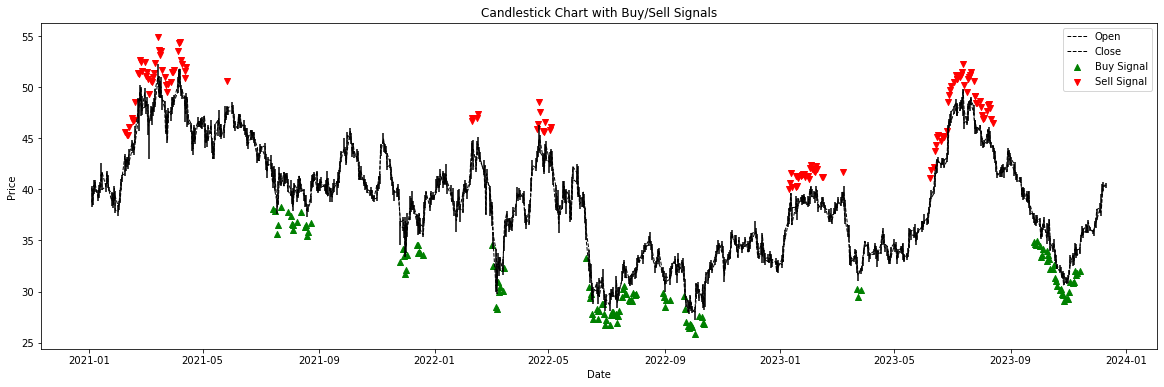

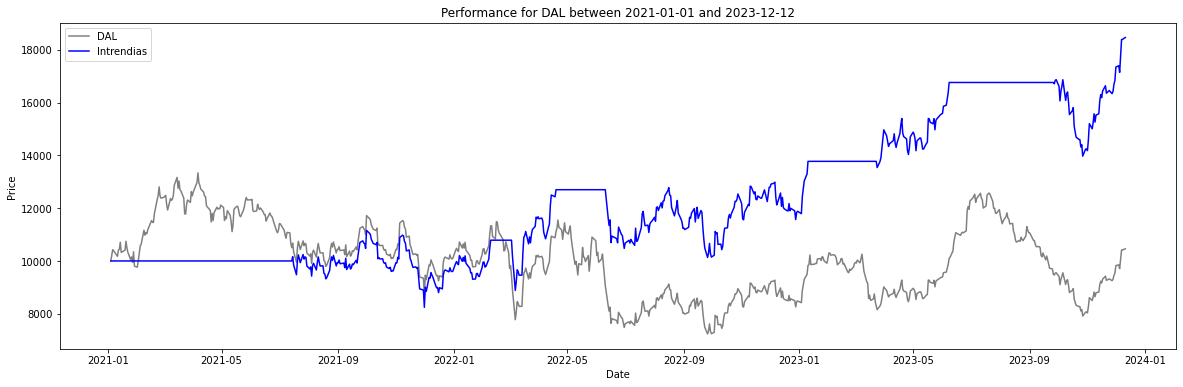

In [ ]:
chart_from_mean_reversion(ticker = 'DAL', start_date = pastDate, end_date = currentDate, interval = '1d')